In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set(
    context="talk",
    style="whitegrid",
    rc={
        "figure.figsize": (16, 8),
        "figure.dpi": 100,
    },
)

# Data Loading

In [5]:
!cd ..; dvc repro ensemble_10km_test

'datasets/ensemble_10km_test.nc.dvc' didn't change, skipping          core>
Stage 'ensemble_10km_test' didn't change, skipping
Data and pipelines are up to date.


In [6]:
prepared_dataset = pathlib.Path("../datasets/prepared/ensemble_10km_test/ensemble_10km_test.hdf")

X = pd.read_hdf(prepared_dataset, key="inputs")
y = pd.read_hdf(prepared_dataset, key="outputs")
Xy = pd.read_hdf(prepared_dataset, key="inputs_outputs")

<AxesSubplot:xlabel='melt_rate', ylabel='SLC'>

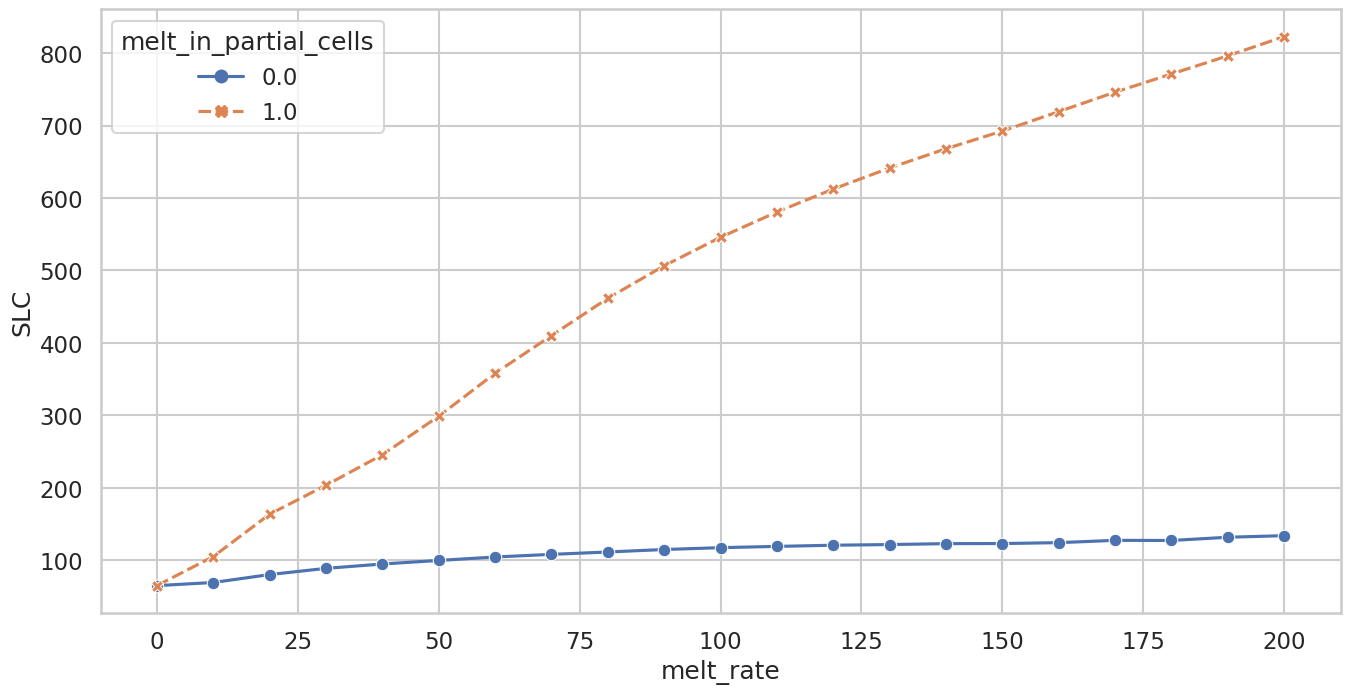

In [7]:
sns.lineplot(
    x="melt_rate",
    y="SLC",
    hue="melt_in_partial_cells",
    style="melt_in_partial_cells",
    data=Xy,
    markers=True,
)

# Modelling

In [8]:
import GPy

In [9]:
indexers = [
    X["melt_in_partial_cells"] == 0.0,
    X["melt_in_partial_cells"] == 1.0,
]
indexers = [indexer.values for indexer in indexers]

In [10]:
X_test = np.mgrid[-20.0:220.0:200j][:, None]
X_test_indexers = [
    np.zeros_like(X_test),
    np.ones_like(X_test),
]

colors = ["C0", "C1"]

In [11]:
Xs = [X.values[indexer][:, [0]] for indexer in indexers]
ys = [y.values[indexer] for indexer in indexers]

In [12]:
import wavi_on_ray


def coreg_model(Xs, ys, with_linear=False):
    if with_linear:
        kernels = ["bias", "linear", "matern32"]
    else:
        kernels = ["bias", "matern32"]
    return wavi_on_ray.ensemble_10km_test.modelling.build_model(Xs, ys, kernels)

In [13]:
def plot_model(coreg_model, Xs, ys):
    sns.lineplot(
        x="melt_rate",
        y="SLC",
        hue="melt_in_partial_cells",
        style="melt_in_partial_cells",
        data=Xy,
        markers=True,
    )

    for X, y in zip(Xs, ys):
        plt.scatter(X, y, marker="o", c="black", alpha=0.8, s=250)

    for indexer, color in zip(X_test_indexers, colors):
        y_test, y_test_var = coreg_model.predict(
            np.hstack([X_test, indexer]),
            Y_metadata={"output_index": indexer.astype(int)},
        )
        y_test_std = np.sqrt(y_test_var)
        plt.plot(X_test, y_test, c=color)
        plt.fill_between(
            X_test[..., 0],
            y_test[..., 0] - 2 * y_test_std[..., 0],
            y_test[..., 0] + 2 * y_test_std[..., 0],
            color=color,
            alpha=0.4,
        )

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/5, f = 129.27607538381423
Optimization restart 2/5, f = 129.2760697719666
Optimization restart 3/5, f = 129.27603316538458
Optimization restart 4/5, f = 129.27611797012895
Optimization restart 5/5, f = 129.27604181025197


Text(0.5, 1.0, 'Full Data')

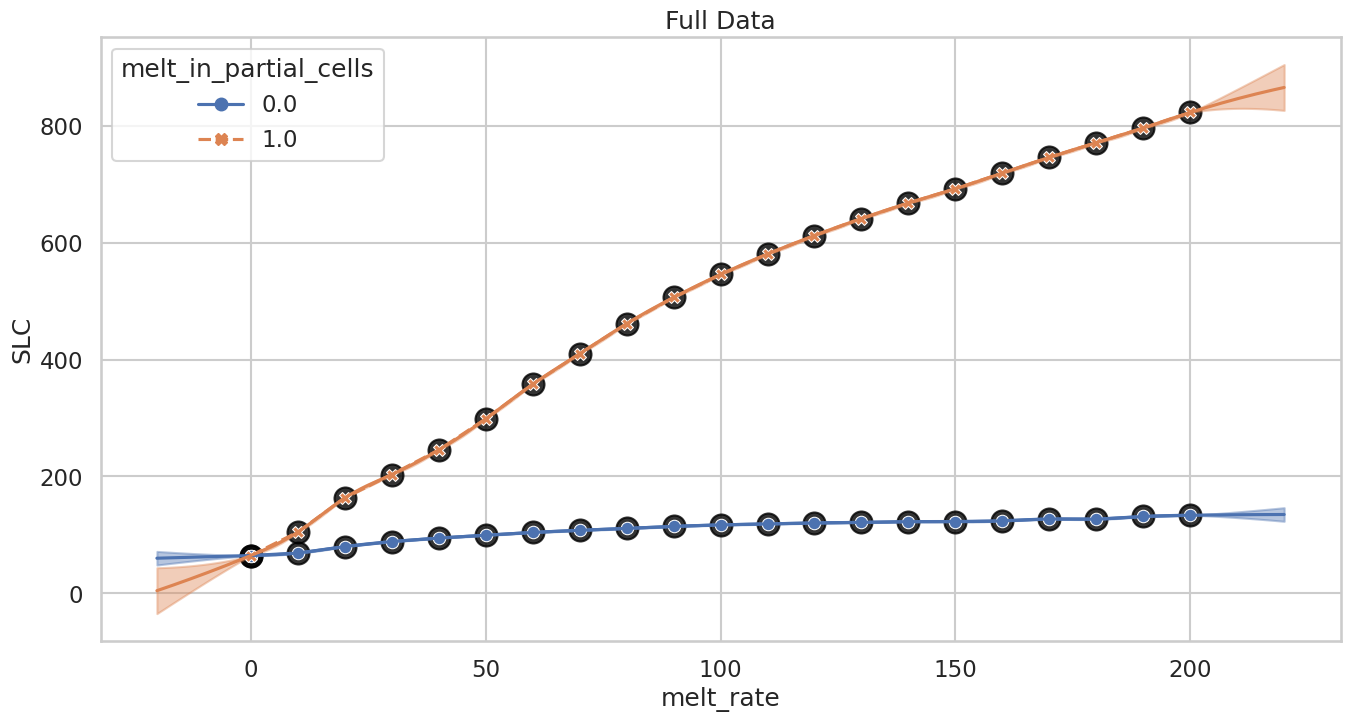

In [14]:
plot_model(coreg_model(Xs, ys), Xs, ys)

plt.title("Full Data")

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/5, f = 34.79666932726076
Optimization restart 2/5, f = 34.79669656258651
Optimization restart 3/5, f = 34.796669287161436
Optimization restart 4/5, f = 34.79666909887672
Optimization restart 5/5, f = 34.79667028020063


gp.,value,constraints,priors
sum.ICM0.bias.variance,0.004646294003506425,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.95239798690407,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,247.79837779227802,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


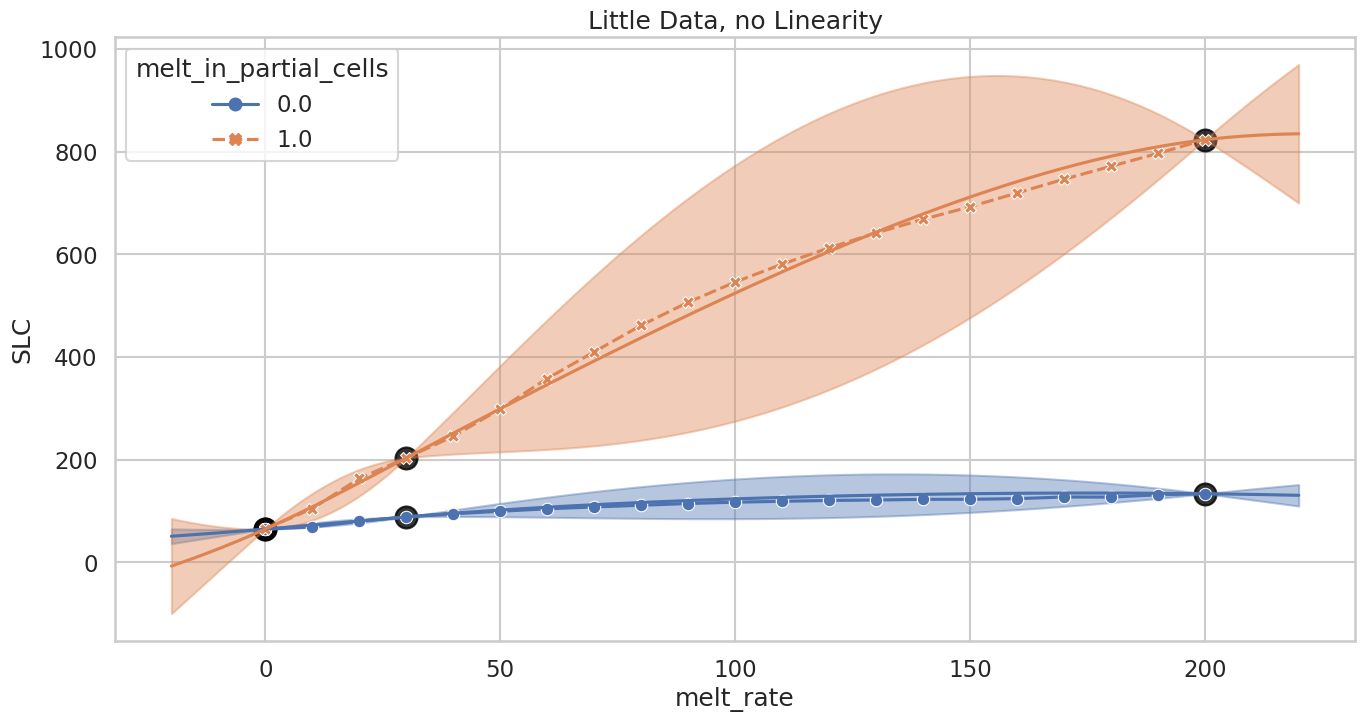

In [15]:
Xs_sub = [
    Xs[0][[0, 3, 20]],
    Xs[1][[0, 3, 20]],
]

ys_sub = [
    ys[0][[0, 3, 20]],
    ys[1][[0, 3, 20]],
]


model = coreg_model(
    Xs_sub,
    ys_sub,
)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, no Linearity")

model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/5, f = 22.667028618114138
Optimization restart 2/5, f = 22.958445531848927
Optimization restart 3/5, f = 22.49845802261549
Optimization restart 4/5, f = 23.156776172111513
Optimization restart 5/5, f = 23.075163026692554


gp.,value,constraints,priors
sum.ICM0.bias.variance,27.075553326841415,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.19051525204043968,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,71.03546029840936,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,409.0030193605818,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


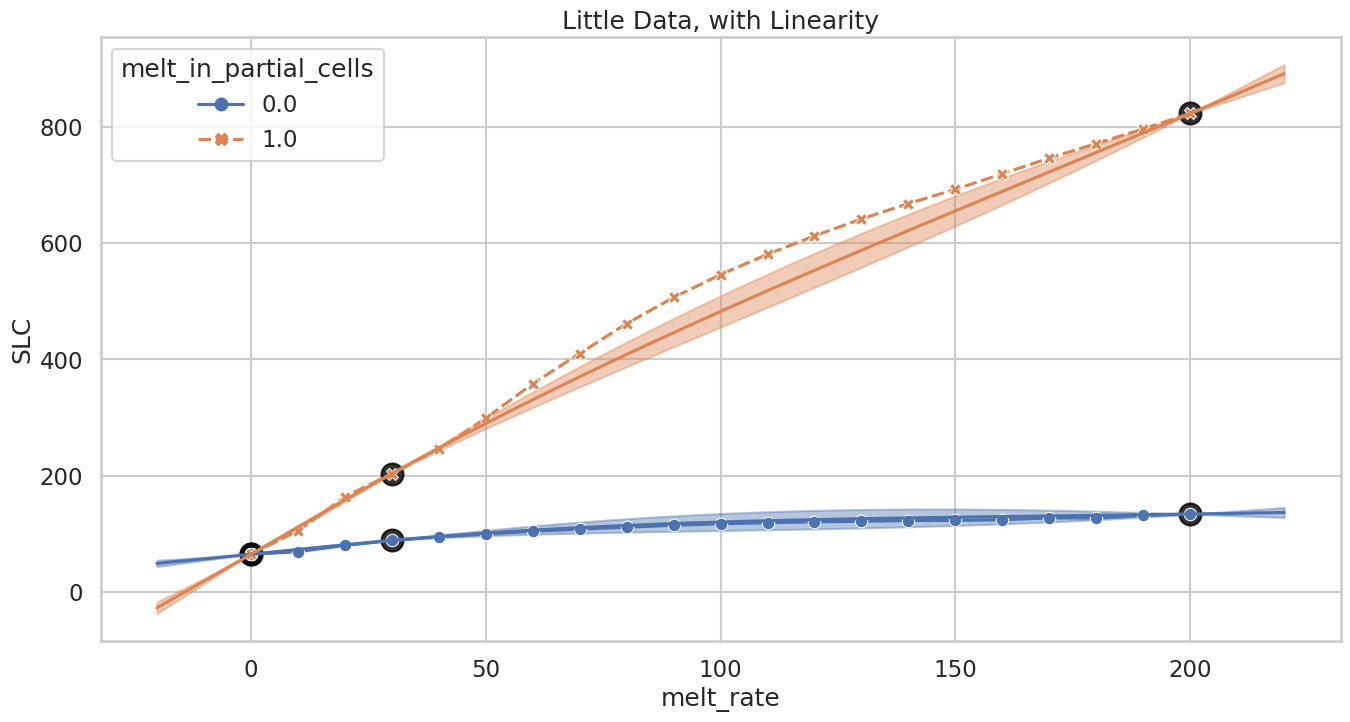

In [16]:
Xs_sub = [
    Xs[0][[0, 3, 20]],
    Xs[1][[0, 3, 20]],
]

ys_sub = [
    ys[0][[0, 3, 20]],
    ys[1][[0, 3, 20]],
]


model = coreg_model(Xs_sub, ys_sub, with_linear=True)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, with Linearity")

model

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/5, f = 44.116928972892836
Optimization restart 2/5, f = 44.11694173632808
Optimization restart 3/5, f = 44.116883602513745
Optimization restart 4/5, f = 44.11698868056009
Optimization restart 5/5, f = 44.116884061294456


gp.,value,constraints,priors
sum.ICM0.bias.variance,0.0007722349434179228,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.87821775240397,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,275.07785612096234,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


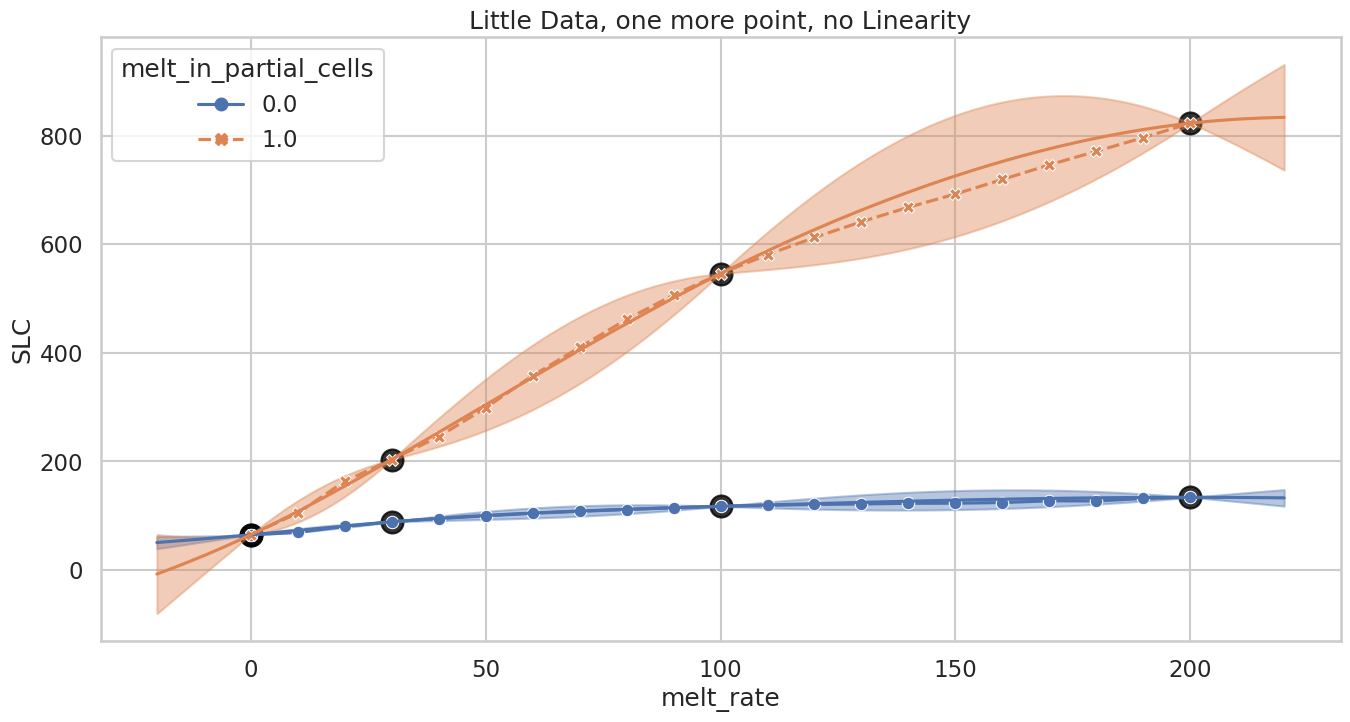

In [17]:
Xs_sub = [
    Xs[0][[0, 3, 10, 20]],
    Xs[1][[0, 3, 10, 20]],
]

ys_sub = [
    ys[0][[0, 3, 10, 20]],
    ys[1][[0, 3, 10, 20]],
]


model = coreg_model(
    Xs_sub,
    ys_sub,
)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, one more point, no Linearity")

model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/5, f = 37.492463767853174
Optimization restart 2/5, f = 37.49241443076022
Optimization restart 3/5, f = 37.49241887769426
Optimization restart 4/5, f = 37.49241078902118
Optimization restart 5/5, f = 37.49240977697613


gp.,value,constraints,priors
sum.ICM0.bias.variance,11.290358252875695,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.00033204671098280856,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,99.99999997096889,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,50.0,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


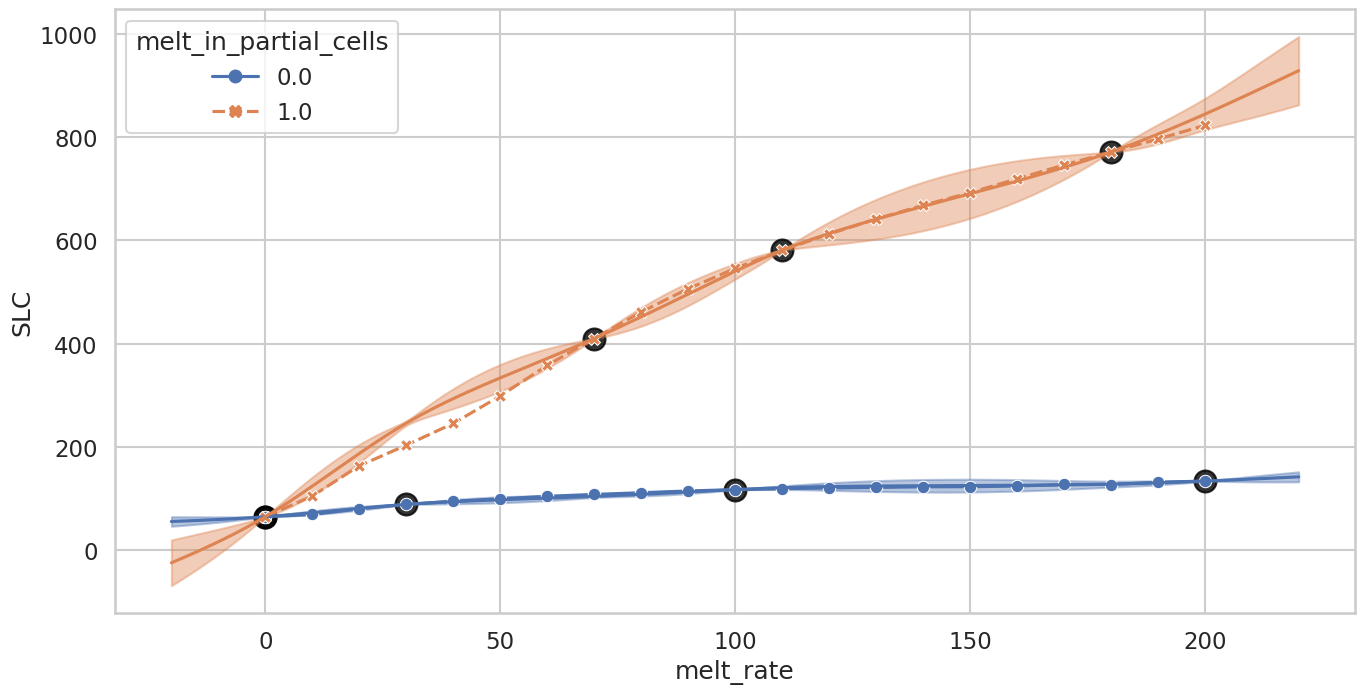

In [18]:
Xs_sub = [
    Xs[0][[0, 3, 10, 20]],
    Xs[1][[0, 7, 11, 18]],
]

ys_sub = [
    ys[0][[0, 3, 10, 20]],
    ys[1][[0, 7, 11, 18]],
]


model = coreg_model(
    Xs_sub,
    ys_sub,
    with_linear=True,
)
plot_model(model, Xs_sub, ys_sub)
model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/5, f = 39.91788566038796
Optimization restart 2/5, f = 39.91788600200677
Optimization restart 3/5, f = 39.917888647172845
Optimization restart 4/5, f = 39.91789763031247
Optimization restart 5/5, f = 39.91788645664311


gp.,value,constraints,priors
sum.ICM0.bias.variance,4.799442706919885,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.0013094900405935493,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,99.99999908270205,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,50.0000000000852,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


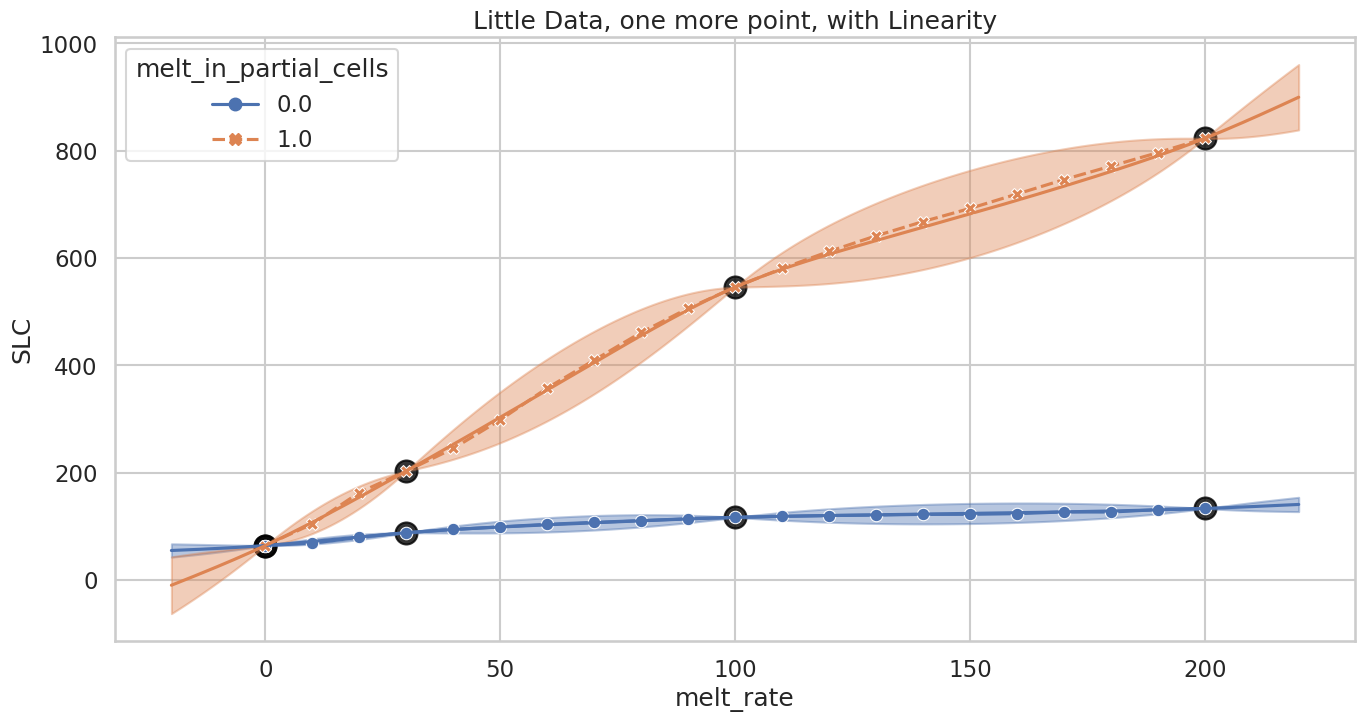

In [19]:
Xs_sub = [
    Xs[0][[0, 3, 10, 20]],
    Xs[1][[0, 3, 10, 20]],
]

ys_sub = [
    ys[0][[0, 3, 10, 20]],
    ys[1][[0, 3, 10, 20]],
]


model = coreg_model(Xs_sub, ys_sub, with_linear=True)
plot_model(model, Xs_sub, ys_sub)
plt.title("Little Data, one more point, with Linearity")

model

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/5, f = 71.96808658084456
Optimization restart 2/5, f = 71.96813941414815
Optimization restart 3/5, f = 71.96811660595998
Optimization restart 4/5, f = 71.96797025444988
Optimization restart 5/5, f = 71.96812442913158


gp.,value,constraints,priors
sum.ICM0.bias.variance,0.9642675451400663,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.99954190878186,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,222.47371422179398,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


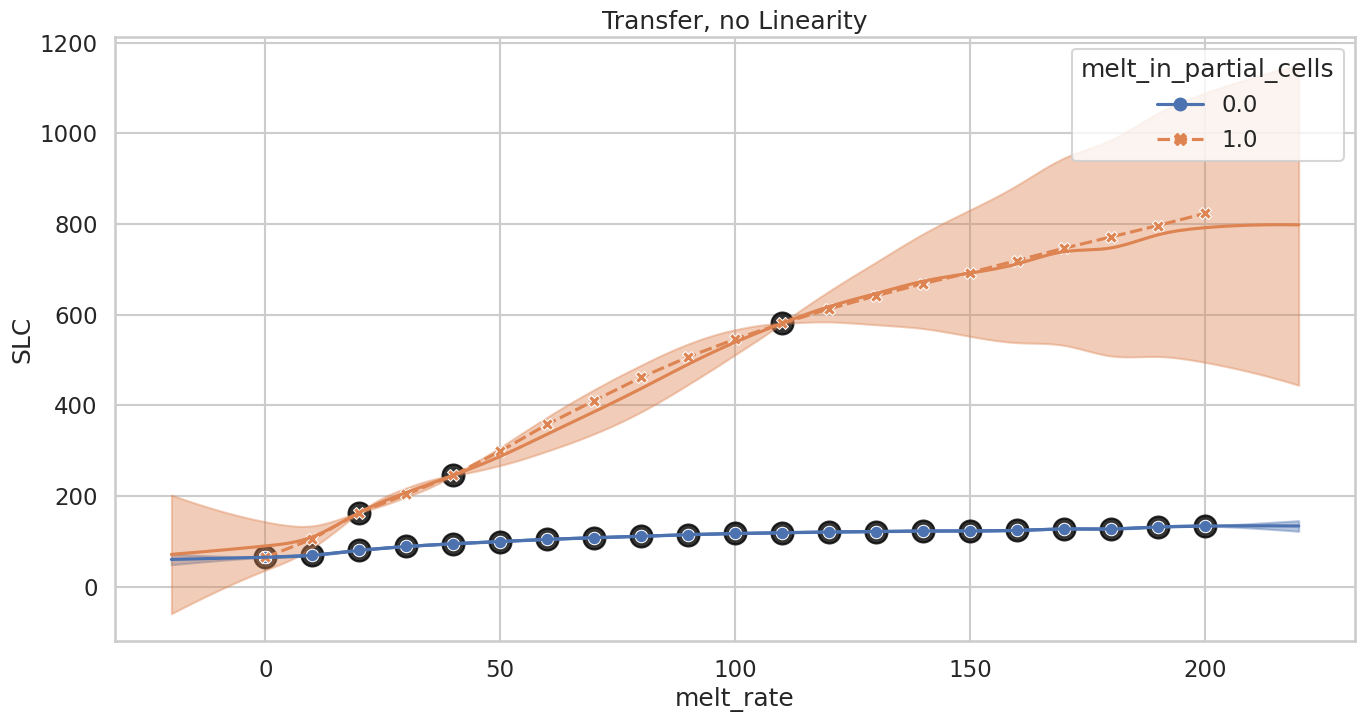

In [20]:
Xs_transfer = [
    Xs[0],
    Xs[1][[2, 4, 11]],
]

ys_transfer = [
    ys[0],
    ys[1][[2, 4, 11]],
]

model = coreg_model(
    Xs_transfer,
    ys_transfer,
)
plot_model(model, Xs_transfer, ys_transfer)
plt.title("Transfer, no Linearity")

model

reconstraining parameters gp.sum.ICM1.Mat32.variance
reconstraining parameters gp.sum.ICM1.Mat32.lengthscale


Optimization restart 1/5, f = 77.83545960313364
Optimization restart 2/5, f = 77.83535782799886
Optimization restart 3/5, f = 77.8354201369345
Optimization restart 4/5, f = 77.83553622183982
Optimization restart 5/5, f = 77.83544009086954


gp.,value,constraints,priors
sum.ICM0.bias.variance,1.4773772261941271,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.Mat32.variance,99.98515676406365,"30.0,100.0",
sum.ICM1.Mat32.lengthscale,223.47552820672507,"50.0,500.0",
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
mixed_noise.Gaussian_noise_0.variance,1e-08,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-08,+ve fixed,


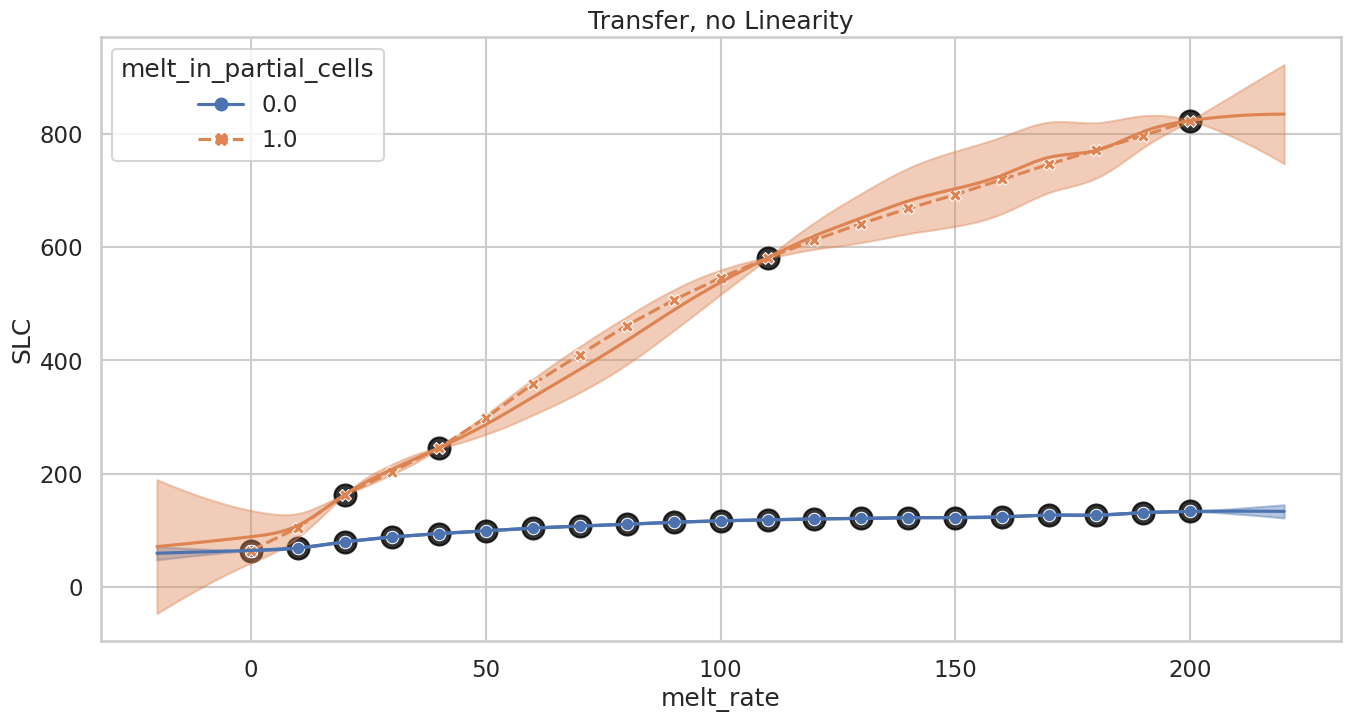

In [21]:
Xs_transfer = [
    Xs[0],
    Xs[1][[2, 4, 11, 20]],
]

ys_transfer = [
    ys[0],
    ys[1][[2, 4, 11, 20]],
]

model = coreg_model(
    Xs_transfer,
    ys_transfer,
)
plot_model(model, Xs_transfer, ys_transfer)
plt.title("Transfer, no Linearity")

model

reconstraining parameters gp.sum.ICM2.Mat32.variance
reconstraining parameters gp.sum.ICM2.Mat32.lengthscale


Optimization restart 1/5, f = 54.3345203333224
Optimization restart 2/5, f = 57.38300504439726
Optimization restart 3/5, f = 56.028847249225855
Optimization restart 4/5, f = 55.67181055255511
Optimization restart 5/5, f = 55.303928770442994


gp.,value,constraints,priors
sum.ICM0.bias.variance,17.35376663970014,+ve,
sum.ICM0.B.W,"(2, 1)",,
sum.ICM0.B.kappa,"(2,)",+ve,
sum.ICM1.linear.variances,0.0020239482963161693,+ve,
sum.ICM1.B.W,"(2, 1)",,
sum.ICM1.B.kappa,"(2,)",+ve,
sum.ICM2.Mat32.variance,33.716060849926976,"30.0,100.0",
sum.ICM2.Mat32.lengthscale,50.00163561617052,"50.0,500.0",
sum.ICM2.B.W,"(2, 1)",,
sum.ICM2.B.kappa,"(2,)",+ve,


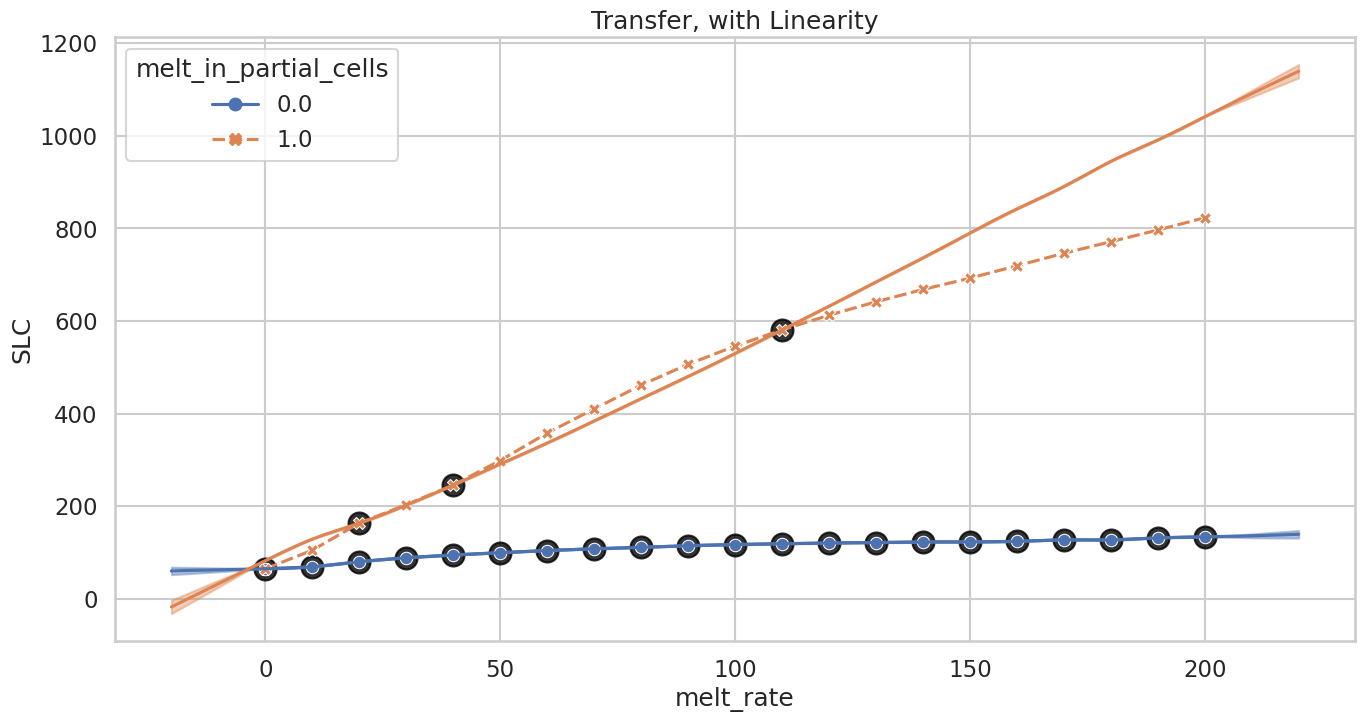

In [22]:
Xs_transfer = [
    Xs[0],
    Xs[1][[2, 4, 11]],
]

ys_transfer = [
    ys[0],
    ys[1][[2, 4, 11]],
]

model = coreg_model(
    Xs_transfer,
    ys_transfer,
    with_linear=True,
)
plot_model(model, Xs_transfer, ys_transfer)
plt.title("Transfer, with Linearity")

model